In [37]:
import numpy as np
import os
import matplotlib.pyplot as plt
import json
import seaborn as sns

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance
from tqdm.notebook import tqdm
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [38]:
def convert_to_ela_image(path,quality):

    original_image = Image.open(path).convert('RGB')

    resaved_file_name = 'resaved_image.jpg'    
    original_image.save(resaved_file_name,'JPEG',quality=quality)
    resaved_image = Image.open(resaved_file_name)

    ela_image = ImageChops.difference(original_image,resaved_image)
    
    extrema = ela_image.getextrema()
    max_difference = max([pix[1] for pix in extrema])
    if max_difference ==0:
        max_difference = 1
    scale = 255 / max_difference
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

In [39]:
def prepare_image(image_path):
    image_size = (128, 128)
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [40]:

X = []
Y = []

In [ ]:
path = 'DATASET/Au/'      
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('jpeg'):
        try:
            full_path = os.path.join(path, filename)
            X.append(prepare_image(full_path))        
            Y.append(1)     
        except:
            pass

print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

In [ ]:
path = 'DATASET/Tp/'      
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
            try:
                full_path = os.path.join(path, filename)
                X.append(prepare_image(full_path))        
                Y.append(0)    
            except:
                pass

   
print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

In [ ]:
from sklearn.utils import shuffle
X = np.array(X)
Y = np.array(Y)
X,Y= shuffle(X,Y)

X = X.reshape(-1, 128, 128, 3)

np.save('proposed_fidac_500_x.npy', X, allow_pickle=True)
np.save('proposed_fidac_500_y.npy', Y, allow_pickle=True)

In [ ]:
X = np.load('./proposed_fidac_500_x.npy', allow_pickle=True)
Y = np.load('./proposed_fidac_500_y.npy', allow_pickle=True)

print(np.shape(X),np.shape(Y))

In [ ]:
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size = 0.05, random_state=5)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size = 0.2, random_state=5)

print(f'Training images: {len(X_train)} , Training labels: {len(Y_train)}')
print(f'Validation images: {len(X_val)} , Validation labels: {len(Y_val)}')
print(f'Test images: {len(X_test)} , Test labels: {len(Y_test)}')

In [ ]:
print((Y_train==1).sum())

In [ ]:
train_gen = ImageDataGenerator(
    featurewise_center=False,  #image pixel = image pixel - mean of all image pixels (for every pixel in every image)
    samplewise_center=False, #t centers each individual image by subtracting its own mean pixel value from every pixel.
    featurewise_std_normalization=False, # this option will normalize the entire dataset by dividing each pixel by the standard deviation of the pixel values calculated from the training set.
    samplewise_std_normalization=False, #this option will normalize each individual image by dividing its pixel values by the standard deviation of that image's pixel values
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
)
test_gen =  ImageDataGenerator()

train_gen.fit(X_train)
test_gen.fit(X_val)

augmented_data = []

In [ ]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (5,5), activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPool2D(2, 2))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPool2D(2, 2))
    
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPool2D(2, 2))
    
    model.add(Conv2D(256, (3,3), activation='relu'))
    model.add(Conv2D(256, (3,3), activation='relu', padding="same"))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [ ]:
model = build_model()
model.summary()

In [ ]:
epochs = 50
batch_size = 19

In [ ]:
init_lr = 1e-4  
optimizer = Adam(learning_rate = init_lr) 
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0,
                               patience = 10,
                               verbose = 0,
                               mode = 'auto')

In [ ]:
hist = model.fit(
    train_gen.flow(X_train, Y_train, batch_size=19),
    epochs=epochs,
    validation_data=train_gen.flow(X_val, Y_val, batch_size=19)
)

In [ ]:
model.save('image_forgery_detection.keras') 

history_dict = hist.history
json.dump(history_dict, open('model_history', 'w'))

In [41]:
with open('model_history', 'r') as f:
    history_dict = json.load(f)

In [42]:
model = load_model('./image_forgery_detection.keras')

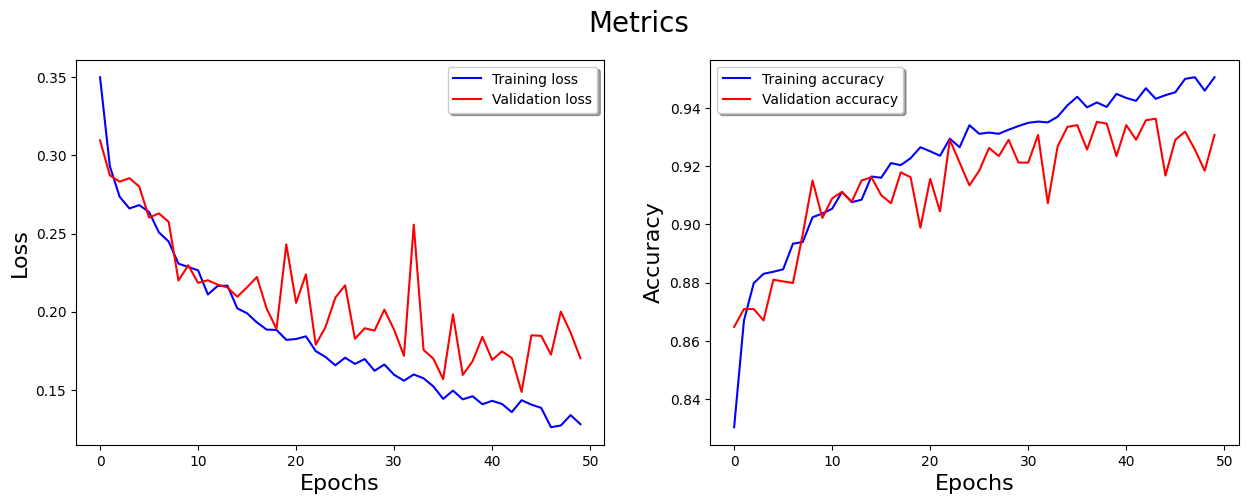

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot Training and Validation Loss
ax[0].plot(history_dict['loss'], color='b', label="Training loss")
ax[0].plot(history_dict['val_loss'], color='r', label="Validation loss")
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Loss', fontsize=16)
ax[0].legend(loc='best', shadow=True)

# Plot Training and Validation Accuracy
ax[1].plot(history_dict['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history_dict['val_accuracy'], color='r', label="Validation accuracy")
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Accuracy', fontsize=16)
ax[1].legend(loc='best', shadow=True)

# Set the main title
fig.suptitle('Metrics', fontsize=20)
plt.show()


In [ ]:
def plot_confusion_matrix(cf_matrix):
  
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    axes_labels=['Forged', 'Authentic']
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='',cmap="flare" , xticklabels=axes_labels, yticklabels=axes_labels)

    plot_xlabel = plt.xlabel('Predicted labels', fontsize = 13)
    plot_ylabel = plt.ylabel('True labels', fontsize = 13)
    plot_title = plt.title('Confusion Matrix', fontsize= 10,fontweight='bold')

In [ ]:
Y_pred = model.predict(X_val)              
Y_pred_classes = np.round(Y_pred)           
Y_true = Y_val                             

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)     
plot_confusion_matrix(confusion_mtx)  

In [ ]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.77      0.69      0.72       434
           1       0.88      0.88      0.85      1356

    accuracy                           0.86      1790
    macroavg       0.82      0.76      0.79      1790
    weightedavg    0.85      0.86      0.85      1790


In [45]:
class_names = ['Forged', 'Authentic']

In [ ]:
correct_test = 0
total_test = 0  

for index,image in enumerate(tqdm(X_test,desc="Processing Images : ")):
    image = image.reshape(-1, 128, 128, 3)
    y_pred = model.predict(image)
    y_pred_class = np.round(y_pred)
    total_test += 1
    if y_pred_class == Y_test[index]: 
        correct_test += 1
    
print(f'Total test images: {total_test}\nCorrectly predicted images: {correct_test}\nAccuracy: {correct_test / total_test * 100.0} %')

In [46]:
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction: Authentic
Confidence: 97.88%
--------------------------------------------------------------------------------------------------------------


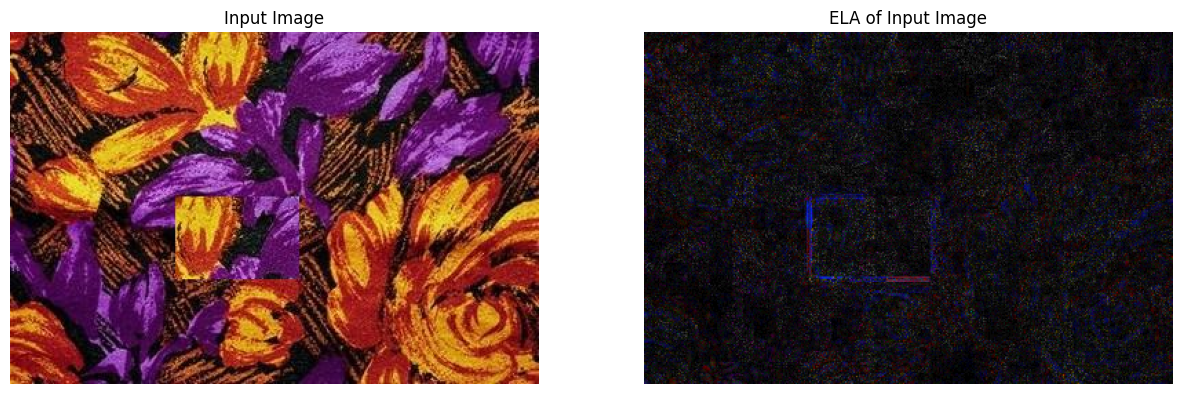

In [ ]:
import random
from pathlib import Path

test_image_path = './TEST/'    # test image path

folder_path = "./TEST/"

# Get a list of all files in the folder
image_files = [f for f in Path(folder_path).iterdir() if f.is_file() and f.suffix in ['.jpg', '.jpeg', '.png']]


# Randomly select an image file
selected_image = random.choice(image_files)
print(selected_image)
test_image = prepare_image(selected_image)
test_image = test_image.reshape(-1, 128, 128, 3)

y_pred = model.predict(test_image)
y_pred_class = int(round(y_pred[0][0]))


fig, ax = plt.subplots(1,2,figsize=(15,5)) 

original_image = plt.imread(selected_image) 
ax[0].axis('off')
ax[0].imshow(original_image)
ax[0].set_title('Input Image')

ax[1].axis('off')
ax[1].imshow(convert_to_ela_image(selected_image,90)) 
ax[1].set_title('ELA of Input Image')

print(f'Prediction: {class_names[y_pred_class]}')
if y_pred<=0.5:
    print(f'Confidence:  {(1-(y_pred[0][0])) * 100:0.2f}%')
else:
    print(f'Confidence: {(y_pred[0][0]) * 100:0.2f}%')
print('--------------------------------------------------------------------------------------------------------------')